In [1]:
import os
import sys
import numpy as np
# import psycopg2
import sqlalchemy
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    context='paper',
    font_scale=8/8.8,
#     context="talk",
    style='ticks',
    color_codes=True,
    rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'

%matplotlib inline

In [2]:
print(np.__version__)
print(pd.__version__)

1.21.2
1.3.3


In [3]:
import nfp
print(nfp.__version__)

2021-11-15 09:59:05.897511: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


0.2.1


2021-11-15 09:59:11.293782: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-11-15 09:59:11.307753: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:37:00.0 name: Quadro GV100 computeCapability: 7.0
coreClock: 1.627GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 810.62GiB/s
2021-11-15 09:59:11.307787: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-11-15 09:59:11.316779: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-11-15 09:59:11.316834: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-11-15 09:59:11.319599: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcufft.so.10
2

In [4]:
os.chdir('../')

In [5]:
print(os.getcwd())
sys.path.append('../../')
import rlmolecule
from rlmolecule.sql.run_config import RunConfig
from rlmolecule.sql import Base, Session
from rlmolecule.sql.tables import GameStore, RewardStore, StateStore

/home/jlaw/projects/arpa-e/crystals/rlmolecule/examples/crystal_energy


In [6]:
# connect to the db
# config_file = "config/config_eagle.yaml"
config_file = "/projects/rlmolecule/jlaw/crystal_energy/pred_energy_test/run.yaml"
run_config = RunConfig(config_file)
engine = run_config.start_engine()
Session.configure(bind=engine)
session = Session()

In [7]:
def load_games_played(session, run_id):
#     print("Loading games")
    df = pd.read_sql(session.query(GameStore).filter_by(run_id=run_id).statement, session.bind)

    df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
    df = df.sort_values('time_hours')
    df_games = df
    df_games.reset_index(drop=True, inplace=True)
#     print(df_games.tail(3))
    return df_games


def load_rewards(session, run_id):
#     print("Loading rewards")
    df = pd.read_sql(session.query(RewardStore).filter_by(run_id=run_id).statement, session.bind)
    # df['time_hours'] = (df.time - df.time.min()).apply(lambda x: x.total_seconds() / 3600)
    df = df.sort_values('reward', ascending=False)
    df_rew = df
#     print(df_rew.tail(3))
    return df_rew


def load_states(session, run_id):
#     print("Loading rewards")
    df = pd.read_sql(session.query(StateStore).filter_by(run_id=run_id).statement, session.bind)
    return df

def get_state_for_rew(digest, df_state):
    return df_state[df_state['digest'] == digest]


# def write_best_crystals():
#     df_rew = load_rewards

In [8]:
def plot_reward(df, log, out_dir, title=""):
    fig, ax = plt.subplots(figsize=(3, 2.75), dpi=150)
    axs = [ax]
    axs[0].plot(df.time_hours, df.raw_reward, '.', ms=.75, label='games')
    axs[0].plot(df.time_hours, df.raw_reward.rolling(250, min_periods=50).quantile(.75), label='$r_{75}$')

    axs[0].legend(loc='upper right', ncol=2, borderpad=0, borderaxespad=0,
                bbox_to_anchor=(1.1, 1.2), markerscale=10)

    axs[0].set_yticks(np.arange(-5, 5, 2))
    axs[0].set_ylabel('Reward')

    plt.tight_layout()
    sns.despine(offset=5, trim=True)
    plt.title(title)

    out_file = f"{out_dir}/training.svg"
    print(out_file)
    os.makedirs(os.path.dirname(out_file), exist_ok=True)
    plt.savefig(out_file, bbox_inches="tight")
    plt.savefig(out_file.replace('.svg','.pdf'), bbox_inches="tight")
    plt.savefig(out_file.replace('.svg','.png'), bbox_inches="tight")
    plt.show()
    plt.close()

In [9]:
def plot_reward_train_curves(df, log, out_dir, title=""):
    fig, axs = plt.subplots(sharex=True, nrows=2, figsize=(3, 2.75), dpi=150)
    axs[0].plot(df.time_hours, df.raw_reward, '.', ms=.75, alpha=.5, label='games')
    axs[0].plot(df.time_hours, df.raw_reward.rolling(250, min_periods=50).quantile(.75), label='$r_{75}$')

    axs[1].plot(log.time_hours, log.policy_wrapper_loss, label='value loss')
    axs[1].plot(log.time_hours, log.policy_wrapper_1_loss, label='prior loss')

    axs[0].legend(loc='upper right', ncol=2, borderpad=0, borderaxespad=0,
                bbox_to_anchor=(1.1, 1.2), markerscale=10)
    axs[1].legend(
        loc='upper right', ncol=2,
        borderpad=0, borderaxespad=0.1,
        bbox_to_anchor=(1.1, 1.2))

    #axs[1].set_ylim([0, .7])
    #axs[1].set_xlim([-.01, 4])
    axs[0].set_yticks(np.arange(-2, 5, 2))
    axs[0].set_ylim(-2, 4.1)
    axs[1].set_yticks(np.arange(0, .7, .2))
    axs[1].set_ylim(0, .62)
    axs[0].set_ylabel('Reward')
    axs[1].set_ylabel('Policy Training')
    axs[1].set_xlabel('Time (hours)')

    plt.tight_layout()
    sns.despine(offset=5, trim=True)
    plt.suptitle(title, y=1.0)

    out_file = f"{out_dir}/training-and-reward.svg"
    print(out_file)
    os.makedirs(os.path.dirname(out_file), exist_ok=True)
#     plt.savefig(out_file, bbox_inches="tight")
#     plt.savefig(out_file.replace('.svg','.pdf'), bbox_inches="tight")
    plt.savefig(out_file.replace('.svg','.png'), bbox_inches="tight")
    plt.show()
    plt.close()

# Compare Experiment Results

In [10]:
exp_name = "crystal_energy"
run_id = run_config.run_id
print(run_id)

pred_energy_test


In [11]:
def main_results(run_id, session):
    working_dir = f"/projects/rlmolecule/jlaw/{exp_name}/{run_id}"
    # load the games played
    df_games = load_games_played(session, run_id)
#     print(df_games.head(2))
#     print(len(df_games))

    log_file = f"{working_dir}/policy_checkpoints/log.csv"
    print(f"Reading {log_file}")
    log = pd.read_csv(log_file)
    log['time'] = pd.to_datetime(log.time)
    log['time'] = pd.to_datetime(log.time)
    log['time_hours'] = (log.time - df_games.time.min()).apply(lambda x: x.total_seconds() / 3600)
#     print(log.tail(3))

    # now plot the results
    out_dir = f"{working_dir}/viz"
#     plot_reward(df_games, log, out_dir, title=run_id)
#     plot_reward_train_curves(df_games, log, out_dir, title=run_id)
    plot_reward_train_curves(df_games, log, out_dir)

    # and write POSCAR files for the best molecules
    df_rew = load_rewards(session, run_id)
#     print(df_rew.head(2))
    return df_games, df_rew

Reading /projects/rlmolecule/jlaw/crystal_energy/pred_energy_test/policy_checkpoints/log.csv
/projects/rlmolecule/jlaw/crystal_energy/pred_energy_test/viz/training.svg


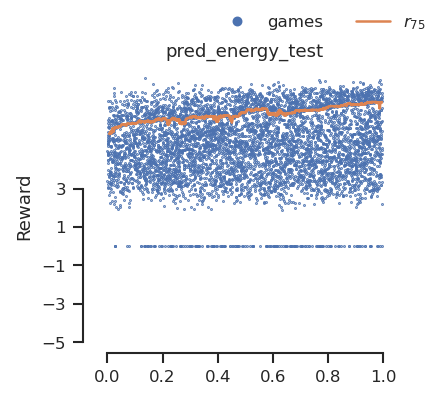

In [14]:
df_games, df_rew = main_results(run_id, session)

Reading /projects/rlmolecule/jlaw/crystal_energy/hull_energy_batt_origlatt/policy_checkpoints/log.csv
/projects/rlmolecule/jlaw/crystal_energy/hull_energy_batt_origlatt/viz/training-and-reward.svg


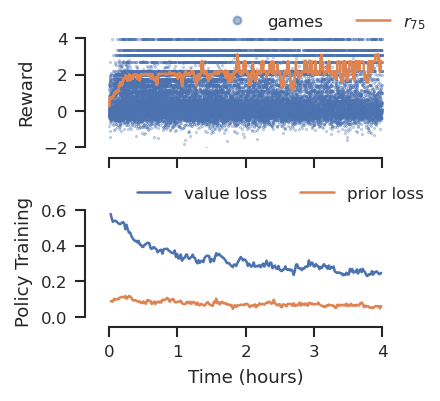

In [12]:
run_id = "hull_energy_batt_origlatt"
df_games, df_rew = main_results(run_id, session)

Reading /projects/rlmolecule/jlaw/crystal_energy/decomp_energy_nocomp_batt_rel_origlatt/policy_checkpoints/log.csv
/projects/rlmolecule/jlaw/crystal_energy/decomp_energy_nocomp_batt_rel_origlatt/viz/training-and-reward.svg


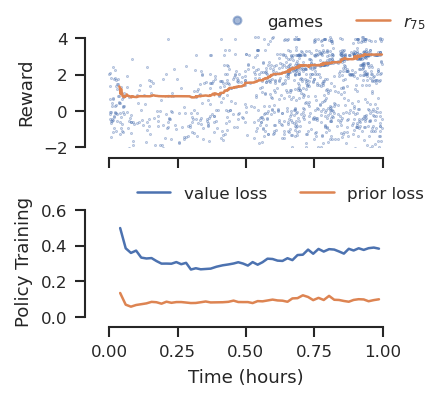

In [194]:
run_id = "decomp_energy_nocomp_batt_rel_origlatt"
df_games, df_rew = main_results(run_id, session)

In [13]:
# plot the hull energy by the predicted energy
df_games.head(2)

id                     run_id  \
0  7f2d12a0-108a-454e-b8e9-c8de5065b9f3  hull_energy_batt_origlatt   
1  d606aab1-ca8a-467f-ae89-aa45d181fc1d  hull_energy_batt_origlatt   

                        time  raw_reward  scaled_reward  \
0 2021-09-25 01:32:38.711135       0.289            1.0   
1 2021-09-25 01:32:38.862404       0.085            1.0   

                                   search_statistics  \
0  [[4f27ce5de30b5dbb727c1b2601211b1e7a7bc4b1ceb3...   
1  [[4f27ce5de30b5dbb727c1b2601211b1e7a7bc4b1ceb3...   

                                execution_statistics  time_hours  
0  {'execution_time': {'get_next_actions': 0.0069...    0.000000  
1  {'execution_time': {'get_next_actions': 0.0063...    0.000042

In [15]:
df_rew.head(2)

digest  \
439120  e32df73c0cb1ec379921802403db7f3c83b3cc2d434870...   
465721  a131fa042e506903d37b93dfe911d2a4af4780c5af1069...   

                       hash                     run_id  \
439120  7485402934523379672  hull_energy_batt_origlatt   
465721  2372185172570303995  hull_energy_batt_origlatt   

                             time  reward  \
439120 2021-09-25 03:18:51.899199   3.961   
465721 2021-09-25 03:27:56.826469   3.961   

                                                     data  
439120  {'terminal': True, 'predicted_energy': -4.9754...  
465721  {'terminal': True, 'predicted_energy': -5.1907...

In [16]:
len(df_rew)

748341

In [17]:
df_rew['hash'].nunique()

457841

In [18]:
print(df_rew[df_rew['reward'] > 3][['hash', 'digest']].nunique())

hash       1522
digest    14862
dtype: int64


In [19]:
# get the unique states
print(df_rew[df_rew['reward'] > 0]['data'].apply(lambda x: x['state_repr']).nunique())
print(df_rew[df_rew['reward'] > 1]['data'].apply(lambda x: x['state_repr']).nunique())
print(df_rew[df_rew['reward'] > 2]['data'].apply(lambda x: x['state_repr']).nunique())

234722
38308
5727


In [21]:
top_states = df_rew[df_rew['reward'] > 2]['data'].apply(lambda x: x['state_repr']).unique()
# get the top states with 3 or more elements
len([s for s in top_states if len(s.split('|')[1]) > 4])

2200

In [22]:
top_rew = df_rew[df_rew['reward'] > 2]
print(len(top_rew))

58051


In [25]:
# see how much repetition there is
crystal_states = []
for data in df_rew['data']:
    crystal_states.append(data['state_repr'])
print(len(crystal_states))
crystal_states = set(crystal_states)
print(len(crystal_states))

748341
457841


In [27]:
# get reward for each decoration
crystal_state_rew = {}
for rew, data in df_rew[['reward', 'data']].values:
    crystal_state_rew[data['state_repr']] = rew
print(len(crystal_state_rew))

457841


In [28]:
print(list(crystal_state_rew.items())[:2])

[('Mg1F2|_1_2|orthorhombic|POSCAR_sg54_icsd_170551|1', 3.961), ('Mg1F2|_1_2|tetragonal|POSCAR_sg92_icsd_620210|1', 3.961)]


In [29]:
crys_comp = [s.split('|')[0] for s in crystal_states]
S = pd.Series(list(crys_comp))
comp_counts = S.value_counts()
# print(list(comp_counts.index))
comp_counts

Zn1F2            418
Mg1F2            418
Li2S1            415
Mg1Cl2           413
Li2O1            413
                ... 
Mg1B2Sn1O5S1       1
Mg1Ti1Cl3P1        1
K1W1Si1Cl2P3       1
Zn1Sc1W1I5N2       1
Mg1Ge1P1Cl1S5      1
Length: 14040, dtype: int64

In [30]:
# see what the best crystals are
best_crystal_states = {}
for rew, data in top_rew[['reward', 'data']].values:
    best_crystal_states[data['state_repr']] = rew
print(len(best_crystal_states))

5727


In [31]:
S = pd.Series(best_crystal_states)
S

Mg1F2|_1_2|orthorhombic|POSCAR_sg54_icsd_170551|1             3.961
Mg1F2|_1_2|tetragonal|POSCAR_sg92_icsd_620210|1               3.961
Mg1F2|_1_2|hexagonal|POSCAR_sg191_icsd_169578|1               3.961
Mg1F2|_1_2|cubic|POSCAR_sg229_icsd_170475|1                   3.961
Mg1F2|_1_2|hexagonal|POSCAR_sg191_icsd_089700|1               3.961
                                                              ...  
Na1Y1Zn4N1P3|_1_1_1_3_4|triclinic|POSCAR_sg2_icsd_056790|4    2.001
Zn4Zr1N1P3|_1_1_3_4|monoclinic|POSCAR_sg15_icsd_075045|1      2.001
Zn4Sn1P4|_1_4_4|orthorhombic|POSCAR_sg62_icsd_418945|2        2.001
Na3Zn2Cd1P3|_1_2_3_3|hexagonal|POSCAR_sg189_icsd_099075|2     2.001
Zn4B1Br2P3|_1_2_3_4|hexagonal|POSCAR_sg186_icsd_420783|1      2.001
Length: 5727, dtype: float64

In [32]:
best_crys_comp = [s.split('|')[0] for s in best_crystal_states]
S = pd.Series(list(best_crys_comp))
comp_counts = S.value_counts()
print(list(comp_counts.index))

['Mg1F2', 'K1F1', 'Na1F1', 'Na1Cl1', 'Li1F1', 'K1Cl1', 'Li1Cl1', 'Zn1F2', 'Mg1Cl2', 'Li2O1', 'Zn3Sc1P3', 'Zn4Zr1P4', 'Zn2F1N1', 'Zn4S1P2', 'Zn5S2N2', 'Zn2I1P1', 'Zn1Sc1Hg1F7', 'Li1Zn4P3', 'Zn1Sc1Cd1F7', 'Zn2F1P1', 'Zn5Br1P3', 'Zn3N1P1', 'Zn4S1N2', 'Zn3Al1P3', 'Zn3La1P3', 'Zn5O2N2', 'K5S1N1', 'Zn2Cl1P1', 'K1La1Zn4P4', 'Mg1Sc1F5', 'Zn4O1P2', 'Zn5Cl1N3', 'Zn5F1P3', 'K5O1N1', 'Zn4Hf1P4', 'K1Zn1N1', 'Zn5I1N3', 'Zn2Sc1F7', 'Na1Zn4N3', 'Zn5I1P3', 'Zn4O1N2', 'Li1Zn3I1P2', 'Na1Zn1N1', 'K1Zn3S2N1', 'Zn6N1P3', 'Zn2Br1P1', 'Zn5Br1N3', 'Zn3F3P1', 'K1Zn2O1N1', 'K7O2N1', 'K7F1N2', 'Li1Zn4N3', 'Zn3F3N1', 'K7Br1N2', 'Na1Y1Zn4N1P3', 'Zn3La1N3', 'Zn5S2P2', 'Zn3Cl3P1', 'Zn5Hg1N4', 'Na1Zn2O1N1', 'K5Zn2N3', 'Mg1Zn4Cl1P3', 'Na1La1Zn4P4', 'Zn5Cl1P3', 'Na1Sc1Zn4P4', 'K1Zn4Al1P4', 'Na1Sc2F7', 'K7I1N2', 'Zn4Cd1O2P2', 'Zn1Sc1F5', 'Na1Zn4B1P4', 'K6N1P1', 'Zn4Zr1N1P3', 'Na1Zn3Cd1P3', 'Li1Y1Zn4P4', 'Na1Y1Zn4P4', 'K5O1P1', 'Zn3I3P1', 'Zn5O2P2', 'Zn6N3P1', 'Na1Zn2S1N1', 'Na1Zn5O1N3', 'Li1Zn5O1N3', 'Mg1Zn5P4', 'K5Zn1Cd

In [33]:
len(comp_counts)

152

In [123]:
decorations = pd.read_csv("/projects/rlmolecule/jlaw/crystals/2021-09-22/all-decorations-c150.txt.gz", 
                          header=None,
                          squeeze=True)
print(len(decorations))
decorations.head(3)

14978150


0     K3P1|_1_3|monoclinic|POSCAR_sg9_icsd_261955|1
1    K3P1|_1_3|monoclinic|POSCAR_sg15_icsd_010490|1
2    K3P1|_1_3|monoclinic|POSCAR_sg15_icsd_039430|1
Name: 0, dtype: object

In [235]:
crys_comp = [s.split('|')[0] for s in decorations]
S = pd.Series(list(crys_comp))
S.value_counts()

Mg1Y1O1N1      984
Na1La1Br1P1    984
Li1Sc1O1S1     984
Na1Hg1Cl1O1    984
Mg1B1S1P1      984
              ... 
K3Sn2F2N3        4
Na2Sb2Br3P3      4
Mg2Hf2Br3P3      4
K3Zn2Br3O2       4
Na3Sn2I2P3       4
Length: 138776, dtype: int64

write a file with: 
- the comp
- num decorations
- num decorations with reward value
- num decorations > cutoff
- fraction that are stable (hull energy < 0) (?)
- avg hull energy

In [212]:
def get_comp_counts(state_rew):
    crys_comp = [s.split('|')[0] for s in state_rew]
    S = pd.Series(list(crys_comp))
    comp_counts = S.value_counts()
    # print(list(comp_counts.index))
    return comp_counts


def get_state_rew(df_rew):
    # get reward for each decoration
    state_rew = {}
    for rew, data in df_rew[['reward', 'data']].values:
        state_rew[data['state_repr']] = rew
    return state_rew
# print(f"{len(state_rew)} / {len(decorations)} states with a reward value")

comp_counts = get_comp_counts(decorations)
df = pd.DataFrame({'comp_counts': comp_counts})
state_rew = get_state_rew(df_rew)
comp_counts = get_comp_counts(state_rew)
df['comp_counts_rew'] = comp_counts

for cutoff in range(4):
    state_rew_cutoff = get_state_rew(df_rew[df_rew['reward'] > cutoff])
    comp_counts_cutoff = get_comp_counts(state_rew_cutoff)
    print(f"{len(comp_counts_cutoff)} compositions with reward > {cutoff}")
    df[f'comp_counts_{cutoff}'] = comp_counts_cutoff
df.head(3)

787 compositions with reward > 0
269 compositions with reward > 1
65 compositions with reward > 2
12 compositions with reward > 3


comp_counts  comp_counts_rew  comp_counts_0  comp_counts_1  \
Mg1Y1O1N1            984              NaN            NaN            NaN   
Na1La1Br1P1          984              NaN            NaN            NaN   
Li1Sc1O1S1           984              NaN            NaN            NaN   

             comp_counts_2  comp_counts_3  
Mg1Y1O1N1              NaN            NaN  
Na1La1Br1P1            NaN            NaN  
Li1Sc1O1S1             NaN            NaN

In [126]:
def get_avg_rew(state_rew):
    comp_rew = defaultdict(list)
    for s, rew in state_rew.items():
        comp = s.split('|')[0]
        comp_rew[comp].append(rew)
    return comp_rew

comp_rew = get_avg_rew(state_rew)
avg_rew = {c: np.mean(rew) for c, rew in comp_rew.items()}
S = pd.Series(avg_rew)
df['avg_rew'] = S
df.head(2)

comp_counts  comp_counts_rew  comp_counts_0  comp_counts_1  \
Mg1Y1O1N1            984              NaN            NaN            NaN   
Na1La1Br1P1          984              NaN            NaN            NaN   

             comp_counts_2  comp_counts_3  avg_rew  
Mg1Y1O1N1              NaN            NaN      NaN  
Na1La1Br1P1            NaN            NaN      NaN

In [34]:
out_dir = f"outputs/{run_id}"
os.makedirs(out_dir, exist_ok=True)

In [ ]:
out_file = f"{out_dir}/comp_stats.csv"
print(out_file)
df.to_csv(out_file)

### Check if the Hull energy value is related to the predicted energy

In [35]:
data

{'terminal': True,
 'predicted_energy': -5.566433906555176,
 'hull_energy': -2.001,
 'num_sites': 20,
 'state_repr': 'Zn4B1Br2P3|_1_2_3_4|hexagonal|POSCAR_sg186_icsd_420783|1'}

In [36]:
state_pred = {}
for rew, data in df_rew[['reward', 'data']].values:
    if 'predicted_energy' in data:
        state_pred[data['state_repr']] = data['predicted_energy']
print(len(state_pred))

440081


In [38]:
df = pd.DataFrame({'predicted_energy': state_pred, 'hull_energy': crystal_state_rew})
df.head()

predicted_energy  \
Mg1F2|_1_2|orthorhombic|POSCAR_sg54_icsd_170551|1         -4.975453   
Mg1F2|_1_2|tetragonal|POSCAR_sg92_icsd_620210|1           -5.190797   
Mg1F2|_1_2|hexagonal|POSCAR_sg191_icsd_169578|1           -3.894496   
Mg1F2|_1_2|cubic|POSCAR_sg229_icsd_170475|1               -5.133155   
Mg1F2|_1_2|hexagonal|POSCAR_sg191_icsd_089700|1           -5.061181   

                                                   hull_energy  
Mg1F2|_1_2|orthorhombic|POSCAR_sg54_icsd_170551|1        3.961  
Mg1F2|_1_2|tetragonal|POSCAR_sg92_icsd_620210|1          3.961  
Mg1F2|_1_2|hexagonal|POSCAR_sg191_icsd_169578|1          3.961  
Mg1F2|_1_2|cubic|POSCAR_sg229_icsd_170475|1              3.961  
Mg1F2|_1_2|hexagonal|POSCAR_sg191_icsd_089700|1          3.961

In [39]:
len(df)

457841

In [149]:
!pip install pandas-bokeh

In [150]:
import pandas_bokeh
pandas_bokeh.output_notebook()

Loading BokehJS ...

In [40]:
out_dir

'outputs/hull_energy_batt_origlatt'

In [47]:
df['composition'] = df.index.map(lambda x: x.split('|')[0])
df.head(2)

predicted_energy  \
Mg1F2|_1_2|orthorhombic|POSCAR_sg54_icsd_170551|1         -4.975453   
Mg1F2|_1_2|tetragonal|POSCAR_sg92_icsd_620210|1           -5.190797   

                                                   hull_energy composition  
Mg1F2|_1_2|orthorhombic|POSCAR_sg54_icsd_170551|1        3.961       Mg1F2  
Mg1F2|_1_2|tetragonal|POSCAR_sg92_icsd_620210|1          3.961       Mg1F2

In [49]:
df_3ele = df[df['composition'].apply(lambda x: len(x) > 5)]
print(len(df_3ele))
df_3ele.head(2)

447671


predicted_energy  \
Zn1Sc1F5|_1_1_5|hexagonal|POSCAR_sg194_icsd_646...         -5.982055   
Zn6N1P3|_1_3_6|monoclinic|POSCAR_sg14_icsd_0270...         -6.363924   

                                                    hull_energy composition  
Zn1Sc1F5|_1_1_5|hexagonal|POSCAR_sg194_icsd_646...        3.025    Zn1Sc1F5  
Zn6N1P3|_1_3_6|monoclinic|POSCAR_sg14_icsd_0270...        3.009     Zn6N1P3

In [67]:
df_3ele['hull_energy'] = -df_3ele['hull_energy']
dft_eval_points = df_3ele[df_3ele['hull_energy'] < -2].groupby('composition').min()
df_3ele['hull_energy'] = -df_3ele['hull_energy']
dft_eval_points['hull_energy'] = - dft_eval_points['hull_energy']
dft_eval_points.head(2)

/tmp/ipykernel_27862/1546988706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3ele['hull_energy'] = -df_3ele['hull_energy']
/tmp/ipykernel_27862/1546988706.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_3ele['hull_energy'] = -df_3ele['hull_energy']


predicted_energy  hull_energy
composition                               
K1La1Zn4N4          -6.756291        2.235
K1La1Zn4P4          -6.137475        2.391

In [77]:
sns.set_context("notebook")

outputs/hull_energy_batt_origlatt/predicted-energy-by-hull-energy.svg


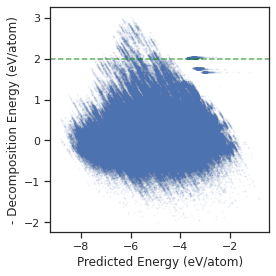

In [81]:
f, ax1 = plt.subplots(figsize=(4,4))

df_3ele[df_3ele['hull_energy'] > -2].plot.scatter(
    x='predicted_energy', y='hull_energy', ax=ax1,
    s=1, alpha=0.05)
# dft_eval_points.plot.scatter(
#     x='predicted_energy', y='hull_energy', ax=ax1,
#     s=5, alpha=0.4, c='green')

# ax1.set_title("All reward values")
ax1.set_ylabel("- Decomposition Energy (eV/atom)", fontsize=12)
ax1.set_xlabel("Predicted Energy (eV/atom)", fontsize=12)

ax1.axhline(y=2, color='green', alpha=.6, linestyle='--')

plt.tight_layout()
out_file = f"{out_dir}/predicted-energy-by-hull-energy.svg"
print(out_file)
# plt.savefig(out_file)
plt.savefig(out_file.replace('.svg','.png'), dpi=300, bbox_inches='tight')
# plt.savefig(out_file.replace('.svg','.pdf'))
plt.show()
plt.close()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


outputs/hull_energy_batt_origlatt/best_decor_per_comp_rew2/predicted-energy-by-hull-energy.svg


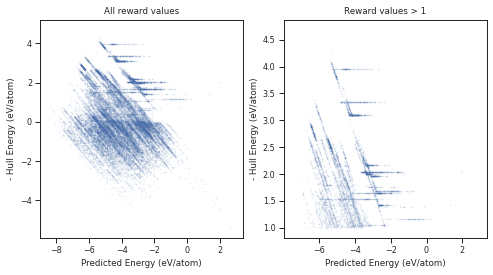

In [220]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,4))

df.plot.scatter(
    x='predicted_energy', y='hull_energy', ax=ax1,
    s=1, alpha=0.05)
df[df['hull_energy'] > 1].plot.scatter(
    x='predicted_energy', y='hull_energy', ax=ax2,
    s=1, alpha=0.05)

# try adding labels:
# df2 = df.reset_index()
# df2[['predicted_energy','hull_energy','index']].apply(lambda x: ax2.text(*x),axis=1)

ax1.set_title("All reward values")
ax2.set_title("Reward values > 1")
for ax in (ax1, ax2):
    ax.set_ylabel("- Hull Energy (eV/atom)")
    ax.set_xlabel("Predicted Energy (eV/atom)")

out_file = f"{out_dir}/predicted-energy-by-hull-energy.svg"
print(out_file)
# plt.savefig(out_file)
plt.savefig(out_file.replace('.svg','.png'))
# plt.savefig(out_file.replace('.svg','.pdf'))
plt.show()
plt.close()

In [223]:
df.to_csv(out_file.replace('.svg','.csv'))

In [155]:
df[df['hull_energy'] > 1].plot_bokeh.scatter(
    x='predicted_energy', y='hull_energy',
    s=1, alpha=0.05)

Figure(id='1039', ...)

In [221]:
from bokeh.io import show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure

In [ ]:
source = ColumnDataSource(data=df[df['hull_energy'] > 1])
p = figure(tools=[HoverTool(tooltips=[('Pred', '@predicted_energy'),
                                     ('Hull', '@hull_energy'),
                                     ('State', '@index')])])
p.scatter(x='predicted_energy', y='hull_energy', size=1, source=source)
show(p)

In [160]:
source = ColumnDataSource(data=df[df['hull_energy'] > 1])
p = figure(tools=[HoverTool(tooltips=[('Pred', '@predicted_energy'),
                                     ('Hull', '@hull_energy'),
                                     ('State', '@index')])])
p.scatter(x='predicted_energy', y='hull_energy', size=1, source=source)
show(p)

### Save the crystals structures of the best states

In [7]:
# TODO automate this step
# I selected the compositions (except for AB comps) 
# that had at least 1 decoration with a decomposition energy < -2
comps_low_decomp = pd.read_csv("outputs/hull_energy_batt_origlatt/comps_low_decomp.csv", header=None, squeeze=True)
comps_low_decomp

0          Zn6N1P3
1         Zn1Sc1F5
2         Zn3Sc1P3
3         Zn4Zr1P4
4          Zn2F1N1
          ...     
137    Zn1Sc1F4Br1
138     Zn3Cd1S1P2
139        Zn3Y1P3
140     Zn4Cd1F1P3
141       Zn4Ti1P4
Name: 0, Length: 142, dtype: object

In [66]:
# for each composition, find the
# build a mapping from composition to decoration string
comp_to_decors = defaultdict(set)
for s, rew in crystal_state_rew.items():
    comp = s.split('|')[0]
    comp_to_decors[comp].add((s, rew))
list(comp_to_decors.items())[-2]

('Li1Y1La2S5',
 {('Li1Y1La2S5|_1_1_2_5|trigonal|POSCAR_sg161_icsd_056913|1', -5.0)})

In [79]:
# now select the decoration with the lowest decomposition energy
comp_low_decomp_energy = {}
for comp in comps_low_decomp:
    max_reward = -10
    for decor, rew in comp_to_decors[comp]:
        if rew > max_reward:
            comp_low_decomp_energy[comp] = (decor, rew)
            max_reward = rew
list(comp_low_decomp_energy.items())[5]

('Zn4S1P2', ('Zn4S1P2|_1_2_4|tetragonal|POSCAR_sg111_icsd_635300|1', 2.883))

In [80]:
comp_low_decomp_energy["Zn1Sc1F5"]

('Zn1Sc1F5|_1_1_5|hexagonal|POSCAR_sg194_icsd_646285|1', 3.025)

In [40]:
# from examples.crystal_volume import optimize_crystal_volume as ocv
from rlmolecule.crystal.crystal_state import CrystalState
from tqdm.notebook import tqdm

In [49]:
import gzip, json
from pymatgen.core import Structure
def read_structures_file(structures_file):
    print(f"reading {structures_file}")
    with gzip.open(structures_file, 'r') as f:
        structures_dict = json.loads(f.read().decode())
    structures = {}
    for key, structure_dict in structures_dict.items():
        structures[key] = Structure.from_dict(structure_dict)
    print(f"\t{len(structures)} structures read")
    return structures

In [50]:
# load the icsd prototype structures
# https://pymatgen.org/usage.html#side-note-as-dict-from-dict
icsd_prototypes_file = "../../rlmolecule/crystal/inputs/icsd_prototypes.json.gz"
structures = read_structures_file(icsd_prototypes_file)

reading ../../rlmolecule/crystal/inputs/icsd_prototypes.json.gz
	4170 structures read


In [88]:
def write_decorated_structure(decorated_str, out_dir, icsd_structures):
    # Now create the decoration of this composition onto this prototype structure
    # the 'action_node' string has the following format at this point:
    # comp_type|prototype_structure|decoration_idx
    # we just need 'comp_type|prototype_structure' to get the icsd structure
    composition = decorated_str.split('|')[0]
    structure_key = '|'.join(decorated_str.split('|')[1:-1])
    icsd_prototype = icsd_structures[structure_key]
    decoration_idx = int(decorated_str.split('|')[-1]) - 1
    print(decorated_str, composition, structure_key)
    try:
        decorated_structure, comp = CrystalState.decorate_prototype_structure(
            icsd_prototype, composition, decoration_idx=decoration_idx)
        #decorations[descriptor] = decorated_structure.as_dict()
    except AssertionError as e:
        print(f"AssertionError: {e}")
        return
        #volume_stats[descriptor] = (-1, -1, 0, comp_type)
        #return 0.0, {'terminal': True, 'state_repr': repr(state)}

    decor_split = decorated_str.split('|')
    out_str = '_'.join([decor_split[0], decor_split[3].replace('POSCAR_',''), decor_split[4]])
    out_file = f"{out_dir}/POSCAR_{out_str}"
    print(f"writing {out_file}")
    decorated_structure.to(filename=out_file)
    
    # also write the original poscar file for reference
    out_file2 = f"{out_dir}/icsd_structures/{decorated_str.split('|')[-2]}"
    os.makedirs(os.path.dirname(out_file2), exist_ok=True)
    if not os.path.isfile(out_file2):
        icsd_prototype.to(filename=out_file2)
        
    return 

In [85]:
run_id = "hull_energy_batt_origlatt"

In [90]:
# now write each of these to a file
out_dir = f"outputs/{run_id}/best_decor_per_comp_rew2"
os.makedirs(out_dir, exist_ok=True)
for comp, (decorated_str, rew) in tqdm(comp_low_decomp_energy.items()):
    write_decorated_structure(decorated_str, out_dir, structures)

  0%|          | 0/142 [00:00<?, ?it/s]

Zn6N1P3|_1_3_6|monoclinic|POSCAR_sg14_icsd_027070|1 Zn6N1P3 _1_3_6|monoclinic|POSCAR_sg14_icsd_027070
writing outputs/hull_energy_batt_origlatt/best_decor_per_comp_rew2/POSCAR_Zn6N1P3_sg14_icsd_027070_1
Zn1Sc1F5|_1_1_5|hexagonal|POSCAR_sg194_icsd_646285|1 Zn1Sc1F5 _1_1_5|hexagonal|POSCAR_sg194_icsd_646285
writing outputs/hull_energy_batt_origlatt/best_decor_per_comp_rew2/POSCAR_Zn1Sc1F5_sg194_icsd_646285_1
Zn3Sc1P3|_1_3_3|cubic|POSCAR_sg198_icsd_000645|2 Zn3Sc1P3 _1_3_3|cubic|POSCAR_sg198_icsd_000645
writing outputs/hull_energy_batt_origlatt/best_decor_per_comp_rew2/POSCAR_Zn3Sc1P3_sg198_icsd_000645_2
Zn4Zr1P4|_1_4_4|orthorhombic|POSCAR_sg23_icsd_245439|2 Zn4Zr1P4 _1_4_4|orthorhombic|POSCAR_sg23_icsd_245439
writing outputs/hull_energy_batt_origlatt/best_decor_per_comp_rew2/POSCAR_Zn4Zr1P4_sg23_icsd_245439_2
Zn2F1N1|_1_1_2|hexagonal|POSCAR_sg194_icsd_153107|2 Zn2F1N1 _1_1_2|hexagonal|POSCAR_sg194_icsd_153107
writing outputs/hull_energy_batt_origlatt/best_decor_per_comp_rew2/POSCAR_Zn2F1

In [132]:
df.head(2)

predicted_energy  hull_energy
Mg1F2|_1_2|monoclinic|POSCAR_sg11_icsd_164631|1         -4.990279        3.961
Mg1F2|_1_2|cubic|POSCAR_sg224_icsd_170483|1             -4.989765        3.961

In [142]:
# write the predicted decomposition energy and energyperatom to file
def format_key(action_str):
    a = action_str.split('|')
    return '_'.join([a[0], a[3].replace('POSCAR_',''), a[4]])

df_out = df[df.index.isin([s for s, e in comp_low_decomp_energy.values()])]
df_out.rename({
    'hull_energy': 'pred_decomp_energy', 
    'predicted_energy': 'pred_energyperatom'}, 
    axis=1, inplace=True)
df_out.rename({key: format_key(key) for key in df_out.index}, axis=0, inplace=True)
df_out.to_csv(f"{out_dir}/pred_energies.csv")
df_out.head(2)

/home/jlaw/.conda/envs/crystals/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


pred_energyperatom  pred_decomp_energy
Zn1Sc1F5_sg194_icsd_646285_1           -5.982055               3.025
Zn6N1P3_sg14_icsd_027070_1             -6.363924               3.009

In [95]:


S = pd.Series({format_key(a): b for a,b in comp_low_decomp_energy.values()})
S.head(2)

Zn6N1P3_sg14_icsd_027070_1      3.009
Zn1Sc1F5_sg194_icsd_646285_1    3.025
dtype: float64

In [104]:
S2 = pd.Series({format_key(key): val for key,val in crystal_state_rew.items()})
df_out = pd.DataFrame({'pred_decomp_energy': S, 'pred_energyperatom': S2})
df_out.dropna(inplace=True)
df_out.head(2)

pred_decomp_energy  pred_energyperatom
K1La1Zn4N4_sg144_icsd_280279_2               2.235               2.235
K1La1Zn4P4_sg11_icsd_245791_4                2.391               2.391

In [98]:
S.to_csv(f"{out_dir}/pred_energies.csv", header=None)

### Backup code for getting states

In [31]:
df_state = load_states(session, run_id)

In [32]:
df_state.head(2)

digest                 hash  \
0  00000b2146003a61d1986c3449893c245a25978937e171...  8851719026745735383   
1  00000edef4b5bf18e4c538f5fbc879550904f0ec926f60...  2197971990852685565   

                      run_id                       time  \
0  hull_energy_batt_origlatt 2021-09-25 01:49:43.449158   
1  hull_energy_batt_origlatt 2021-09-25 02:11:18.837103   

                                               state  \
0  b'x\x9ck`\x99:\x8b\x01\x02z\x14\x8arr\xf3sR\x9...   
1  b'x\x9ck`\x99\xba\x98\x01\x02z\x14\x8arr\xf3sR...   

                                       policy_inputs  
0  b'PK\x03\x04\x14\x00\x00\x00\x08\x00\x00\x00!\...  
1  b"PK\x03\x04\x14\x00\x00\x00\x08\x00\x00\x00!\...

In [34]:
len(df_state)

898172

In [38]:
import pickle
import zlib
from tqdm.notebook import tqdm

In [ ]:
best_states = []
for digest, hash_str, run_id, time, rew, data in tqdm(top_rew.values):
#     if digest in df_state['digest']:
    states = get_state_for_rew(digest, df_state)
    for state_str in states['state']:
#         state_str = get_state_for_rew(digest, df_state)['state'].values[0]
# #     if hash_str in df_state['hash']:
# #         state_str = df_state[df_state['hash'] == hash_str]['state'].values[0]
        crystal = pickle.loads(zlib.decompress(state_str))
        best_states.append(crystal)
len(best_states)

In [47]:
best_decorations = set([str(c) + '|1' if '|1' not in str(c) else str(c) for c in best_states])
len(best_decorations)

0

In [30]:
from examples.crystal_volume import optimize_crystal_volume as ocv
from rlmolecule.crystal.crystal_state import CrystalState
from tqdm.notebook import tqdm

INFO:examples.crystal_volume.optimize_crystal_volume:reading ../../rlmolecule/crystal/inputs/icsd_prototypes.json.gz
INFO:examples.crystal_volume.optimize_crystal_volume:	4170 structures read


In [31]:
def write_decorated_structure(decorated_str, out_dir):
    # Now create the decoration of this composition onto this prototype structure
    # the 'action_node' string has the following format at this point:
    # comp_type|prototype_structure|decoration_idx
    # we just need 'comp_type|prototype_structure' to get the icsd structure
    composition = decorated_str.split('|')[0]
    structure_key = '|'.join(decorated_str.split('|')[1:-1])
    icsd_prototype = ocv.structures[structure_key]
    decoration_idx = int(decorated_str.split('|')[-1]) - 1
    print(decorated_str, composition, structure_key)
    try:
        decorated_structure, comp = CrystalState.decorate_prototype_structure(
            icsd_prototype, composition, decoration_idx=decoration_idx)
        #decorations[descriptor] = decorated_structure.as_dict()
    except AssertionError as e:
        print(f"AssertionError: {e}")
        return
        #volume_stats[descriptor] = (-1, -1, 0, comp_type)
        #return 0.0, {'terminal': True, 'state_repr': repr(state)}

    # Compute the volume of the conducting ions.
    conducting_ion_vol, total_vol = ocv.compute_structure_vol(decorated_structure)
    frac_conducting_ion_vol = conducting_ion_vol / total_vol if total_vol != 0 else 0
#     print(conducting_ion_vol, total_vol, frac_conducting_ion_vol)
    out_file = f"{out_dir}/POSCAR_{decorated_str.replace('|','-')}"
    print(f"writing {out_file}")
    decorated_structure.to(filename=out_file)
    
    # also write the original poscar file for reference
    out_file2 = f"{out_dir}/icsd_structures/{decorated_str.split('|')[-2]}"
    os.makedirs(os.path.dirname(out_file2), exist_ok=True)
    if not os.path.isfile(out_file2):
        icsd_prototype.to(filename=out_file2)
        
    return [conducting_ion_vol, total_vol, frac_conducting_ion_vol]

In [ ]:
# now write each of these to a file
out_dir = f"outputs/{run_id}-0_85"
os.makedirs(out_dir, exist_ok=True)
volume_stats = {}
for decorated_str in tqdm(best_decorations):
    vol_stats = write_decorated_structure(decorated_str, out_dir)
    volume_stats[decorated_str] = [decorated_str.split('|')[-2]] + vol_stats

In [ ]:
df_vol_stats = pd.DataFrame(volume_stats).T
df_vol_stats.columns = ['icsd_prototype', 'conducting_ion_vol', 'total_vol', 'fraction']
df_vol_stats.head()

In [ ]:
out_file = f"{out_dir}/volume_stats.tsv"
df_vol_stats.to_csv(out_file, sep='\t')